In [31]:
import gym
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random
import numpy as np

import gym
import sys
import keras
import numpy as np
import random
import matplotlib.pyplot as plt
from random import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque

In [32]:
class Agent():
    def __init__(self, obs_space, action_space):
        self.obs_space = obs_space
        self.action_space = action_space
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.batch_size = 64
        self.model = self._build_model()

    def remember(self, observation, action, reward, next_observation):
        if len(self.memory) > self.memory.maxlen:
            if np.random.random() < 0.5:
                shuffle(self.memory)
            self.memory.popleft()
        self.memory.append((observation, action, reward, next_observation))

    def get_q(self, observation):
        np_obs = np.reshape(observation, [-1, self.obs_space])
        return self.model.predict(np_obs)

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_shape=(self.obs_space,), activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_space, activation='linear'))
        model.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=[])
        return model

    def update_action(self, action_model, target_model):
        sample_transitions = random.sample(self.memory, self.batch_size)
        random.shuffle(sample_transitions)
        batch_observations = []
        batch_targets = []

        for old_observation, action, reward, observation in sample_transitions:
            # Reshape targets to output dimension(=2)
            targets = np.reshape(
                self.get_q(old_observation),
                self.action_space)
            targets[action] = reward  # Set Target Value
            if observation is not None:
                # If the old state is not a final state, also consider the
                # discounted future reward
                predictions = self.get_q(observation)
                new_action = np.argmax(predictions)
                targets[action] += self.gamma * predictions[0, new_action]

            # Add Old State to observations batch
            batch_observations.append(old_observation)
            batch_targets.append(targets)  # Add target to targets batch

        # Update the model using Observations and their corresponding Targets
        np_obs = np.reshape(batch_observations, [-1, self.obs_space])
        np_targets = np.reshape(batch_targets, [-1, self.action_space])
        self.model.fit(np_obs, np_targets, epochs=1, verbose=0)

    def save(self, path):
        self.model.save_weights(path)

    def load(self, path):
        self.model.load_weights(path)

Episode 000 , epsilon = 1.0000, score = 014

/home/demir/anaconda3/envs/temp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/demir/anaconda3/envs/temp/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
W0930 13:49:08.995202 140624050845504 deprecation_wrapper.py:119] From /home/demir/.local/lib/python3.6/site-packages/Keras-2.0.2-py3.6.egg/keras/backend/tensorflow_backend.py:140: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0930 13:49:08.995885 140624050845504 deprecation_wrapper.py:119] From /home/demir/.local/lib/python3.6/site-packages/Keras-2.0.2-py3.6.egg/keras/backend/tensorflow_backend.py:145: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Episode 002 , epsilon = 0.9801, score = 009

W0930 13:49:09.483739 140624050845504 deprecation.py:506] From /home/demir/.local/lib/python3.6/site-packages/Keras-2.0.2-py3.6.egg/keras/backend/tensorflow_backend.py:519: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Episode 257 , epsilon = 0.0756, score = 499
Environment solved in 257 episodes.

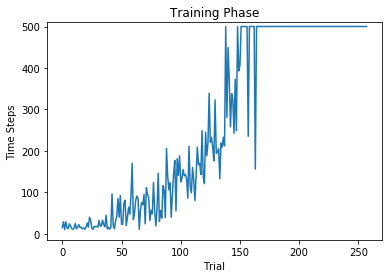

In [33]:

def train():
    env = gym.make('CartPole-v1')
    action_space = env.action_space.n
    observation_space = env.observation_space.shape[0]
    agent = Agent(observation_space, action_space)

    episodes = 600  # Games played in training phase
    max_steps = 500
    epsilon = 1
    epsilon_decay = 0.99
    epsilon_min = 0.05
    scores = []  # A list of all game scores
    recent_scores = []  # List that hold most recent 100 game scores

    for episode in range(episodes):
        observation = env.reset()
        for iteration in range(max_steps):
            old_observation = observation

            if np.random.random() < epsilon:
                # Take random action (explore)
                action = np.random.choice(range(action_space))
            else:
                # Query the model and get Q-values for possible actions
                q_values = agent.get_q(observation)
                action = np.argmax(q_values)
            # Take the selected action and observe next state
            observation, reward, done, _ = env.step(action)
            if done:
                scores.append(iteration + 1)  # Append final score
                # Calculate recent scores
                if len(scores) > 100:
                    recent_scores = scores[-100:]
                # Print end-of-game information
                print(
                    "\rEpisode {:03d} , epsilon = {:.4f}, score = {:03d}".format(
                        episode, epsilon, iteration), end="")
                sys.stdout.flush()
                # Give reward on episode end to accelerate learning
                if iteration != 499:
                    reward = -5  # Give -5 reward for taking wrong action leading to failure
                if iteration == 499:
                    reward = 5  # Give +5 reward for completing the game successfully
                # Add the observation to replay memory
                agent.remember(old_observation, action, reward, None)
                break
            # Add the observation to replay memory
            agent.remember(old_observation, action, reward, observation)
            # Update the Deep Q-Network Model (only with a chance of 25% and
            # when the last score was worse than 495)
            if len(agent.memory) >= agent.batch_size and np.random.random(
            ) < 0.25 and scores[-1] < 495:
                agent.update_action(agent.model, agent.model)

        # If mean over the last 100 Games is >495, then success
        if np.mean(recent_scores) > 495 and iteration > 495:
            print("\nEnvironment solved in {} episodes.".format(episode), end="")
            break
        epsilon = max(epsilon_min, epsilon_decay * epsilon)

    # Saving the model
    agent.model.save('cartpole_model.h5')

    # Plotting
    plt.plot(scores)
    plt.title('Training Phase')
    plt.ylabel('Time Steps')
    plt.ylim(ymax=510)
    plt.xlabel('Trial')
    plt.savefig('CartPoleTraining.png', bbox_inches='tight')
    plt.show()


def test():
    env = gym.make("CartPole-v1")
    action_space = env.action_space.n
    observation_space = env.observation_space.shape[0]
    agent = Agent(observation_space, action_space)
    agent.load("cartpole_model.h5")
    scores = []

    # Playing 100 games
    for _ in range(100):
        obs = env.reset()
        episode_reward = 0
        while True:
            q_values = agent.get_q(obs)
            action = np.argmax(q_values)
            obs, reward, done, _ = env.step(action)
            episode_reward += reward
            if done:
                break
        scores.append(episode_reward)

    # Plot the Performance
    plt.plot(scores)
    plt.title('Testing Phase')
    plt.ylabel('Time Steps')
    plt.ylim(ymax=510)
    plt.xlabel('Trial')
    plt.savefig('CartPoleTesting.png', bbox_inches='tight')
    plt.show()



train()  # Train new weights

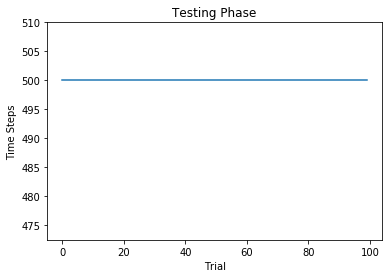

In [34]:
test()  # Use existing weights to play

In [26]:

class DQNAgent():
    def __init__(self, env_id, path, episodes, max_env_steps, win_threshold, epsilon_decay,
                 state_size=None, action_size=None, epsilon=1.0, epsilon_min=0.01, 
                 gamma=1, alpha=.01, alpha_decay=.01, batch_size=16, prints=True):
        self.memory = deque(maxlen=100000)
        self.env = gym.make(env_id)
 
        if state_size is None: 
            self.state_size = self.env.observation_space.n 
        else: 
            self.state_size = state_size
 
        if action_size is None: 
            self.action_size = self.env.action_space.n 
        else: 
            self.action_size = action_size
 
        self.episodes = episodes
        self.env._max_episode_steps = max_env_steps
        self.win_threshold = win_threshold
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.batch_size = batch_size
        self.path = path                     #location where the model is saved to
        self.prints = prints                 #if true, the agent will print his scores
 
        self.model = self._build_model()
        
        print(self.state_size)
  
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='tanh'))
        model.add(Dense(48, activation='tanh'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.alpha, decay=self.alpha_decay))
        return model
    
    def act(self, state):
        if (np.random.random() <= self.epsilon):
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state))

    def remember(self, state, action, reward, next_state, done):      
        self.memory.append((state, action, reward, next_state, done))
        
    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model.predict(state)
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])

        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def fit(self):
        done=False
        score=0
        # Initialize the simulation
        self.env.reset()
        # Reset the game-state, done and score before every episode
        state = self.env.reset()
        
        #state, reward, done, _ = self.env.step(self.env.action_space.sample())

        for i in range(self.episodes):
            action = self.act(state)
            next_state, reward, done, _ = self.env.step(action)
            #print("s:{0} \t--->\t a{1} \t--->\t s':{2} \t-->\t REWARD:{3}".format(state,action,next_state,reward))
            self.remember(state, action, reward, next_state, done)
            
            if i % 10 ==0:
                print('hello')
                self.replay(10)

In [28]:
agent=DQNAgent(env_id="Taxi-v2",path='',episodes=10,max_env_steps=20,win_threshold=9.7,epsilon_decay=0.1)

500


In [25]:
agent.fit()

hello


ValueError: Error when checking : expected dense_22_input to have 2 dimensions, but got array with shape ()